# AN2DL - First Challenge

_Lorenzo Bardelli, Lorenzo Moretti, Luca Zani_

`thegradientdescenders`

In [1]:
# @title Imports and Setup
import os
import sys
# Set seed for reproducibility
SEED = 69

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"

# Create models directory
os.makedirs('models', exist_ok=True)

%load_ext tensorboard

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
import platform
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/gdrive")
    current_dir = "/gdrive/My\ Drive/Colab\ Notebooks/ANNDL"
    %cd $current_dir
else:
    current_dir = os.path.dirname(os.path.abspath("__file__")) if "__file__" in globals() else os.getcwd()
    dataset_dir = os.path.join(current_dir, "dataset")

<>:73: SyntaxWarning: invalid escape sequence '\ '
<>:73: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-4174152765.py:73: SyntaxWarning: invalid escape sequence '\ '
  current_dir = "/gdrive/My\ Drive/Colab\ Notebooks/ANNDL"


PyTorch version: 2.8.0+cu126
Device: cuda
Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ANNDL


In [2]:
# @title Data loading
# Set path to local dataset folder
if IN_COLAB:
    os.environ["DATASET_NAME"] = "pirate_pain_train.csv"
    os.environ["DATASET_URL"] = "1qiKAdJ22NnBMQzIyos_efP2Yxgkvqq8O"

    # Check if dataset exists, download and unzip if not
    if not os.path.exists(os.environ["DATASET_NAME"]):
        print("Downloading pirate pain dataset...")
        !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
        print("Pirate pain dataset downloaded!")
    else:
        print("Pirate pain dataset already downloaded. Using cached data.")

    dataset = pd.read_csv('pirate_pain_train.csv')
    dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
else:
    train_csv_path = os.path.join(dataset_dir, "pirate_pain_train.csv")
    train_labels_path = os.path.join(dataset_dir, "pirate_pain_train_labels.csv")
    test_csv_path = os.path.join(dataset_dir, "pirate_pain_test.csv")
    sample_submission_path = os.path.join(dataset_dir, "sample_submission.csv")

    dataset = pd.read_csv('dataset/pirate_pain_train.csv')
    dataset_labels = pd.read_csv('dataset/pirate_pain_train_labels.csv')

print(f"Dataset shape: {dataset.shape}")
print(f"Dataset labels shape: {dataset_labels.shape}")

dataset.head()

Pirate pain dataset already downloaded. Using cached data.
Dataset shape: (105760, 40)
Dataset labels shape: (661, 2)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [3]:
def inspect_dataframe(df, samples, columns):
    # Create subplots for each column
    figs, axs = plt.subplots(len(columns), len(samples), sharex=True, figsize=(20, 80))

    # Fix: Ensure axs is always 2D array
    if len(samples) == 1:
        axs = axs.reshape(-1, 1)  # Convert to 2D: (rows, 1)
    if len(columns) == 1:
        axs = axs.reshape(1, -1)  # Convert to 2D: (1, cols)

    # Reset index when filtering
    rows = [df[df.iloc[:, 0] == sample].reset_index(drop=True) for sample in samples]

    for j in range(len(samples)):
        for i, col in enumerate(columns):
            axs[i][j].plot(rows[j][col])
            axs[i][j].set_title(col)

    # Display the plots
    plt.show()

## Data preparation

In [4]:
def preprocess_stringed_num(value):
    if isinstance(value, pd.Series):
        return value.apply(preprocess_stringed_num)
    if value == 1 or value == "one+peg_leg" or value == "one+hook_hand" or value == "one+eye_patch":
        return np.int8(1)
    elif value == 2 or value == "two":
        return np.int8(2)
    raise ValueError(f"Unexpected value: {value}")

dataset['n_legs'] = preprocess_stringed_num(dataset['n_legs'])
dataset['n_hands'] = preprocess_stringed_num(dataset['n_hands'])
dataset['n_eyes'] = preprocess_stringed_num(dataset['n_eyes'])

# Create a single binary feature for pirate characteristics
# 0 = has all body parts (normal), 1 = missing all three (pirate)
dataset['is_pirate'] = (dataset['n_legs'] == 1).astype(np.int8)

# Drop the redundant columns (they're perfectly correlated)
dataset = dataset.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

# Stratified split: ensure pirate distribution is proportional across splits
user_pirate_status = dataset.groupby('sample_index')['is_pirate'].first()

# Separate users into pirates and non-pirates
pirate_users = user_pirate_status[user_pirate_status == 1].index.values
normal_users = user_pirate_status[user_pirate_status == 0].index.values

# Shuffle both groups with different seeds for better distribution
random.seed(SEED + 42)
random.shuffle(pirate_users)
random.seed(SEED + 100)  # Different seed for normal users
random.shuffle(normal_users)

# Calculate split sizes for each group (80/10/10 split)
n_val_pirates = max(1, int(0.1 * len(pirate_users)))  # At least 1 if possible
n_test_pirates = max(1, int(0.1 * len(pirate_users)))
n_train_pirates = len(pirate_users) - n_val_pirates - n_test_pirates

n_val_normal = int(0.1 * len(normal_users))
n_test_normal = int(0.1 * len(normal_users))
n_train_normal = len(normal_users) - n_val_normal - n_test_normal

# Split pirate users
train_pirates = pirate_users[:n_train_pirates]
val_pirates = pirate_users[n_train_pirates:n_train_pirates + n_val_pirates]
test_pirates = pirate_users[n_train_pirates + n_val_pirates:]

# Split normal users
train_normal = normal_users[:n_train_normal]
val_normal = normal_users[n_train_normal:n_train_normal + n_val_normal]
test_normal = normal_users[n_train_normal + n_val_normal:]

# Combine both groups for each split
train_users = np.concatenate([train_pirates, train_normal])
val_users = np.concatenate([val_pirates, val_normal])
test_users = np.concatenate([test_pirates, test_normal])

# Split the dataset based on user IDs
df_train = dataset[dataset['sample_index'].isin(train_users)]
df_val = dataset[dataset['sample_index'].isin(val_users)]
df_test = dataset[dataset['sample_index'].isin(test_users)]



Label Distribution Across Splits:
           Training  Validation  Test
no_pain         407          53    51
low_pain         79           6     9
high_pain        43           7     6

Percentages:
           Training  Validation   Test
no_pain       76.94       80.30  77.27
low_pain      14.93        9.09  13.64
high_pain      8.13       10.61   9.09


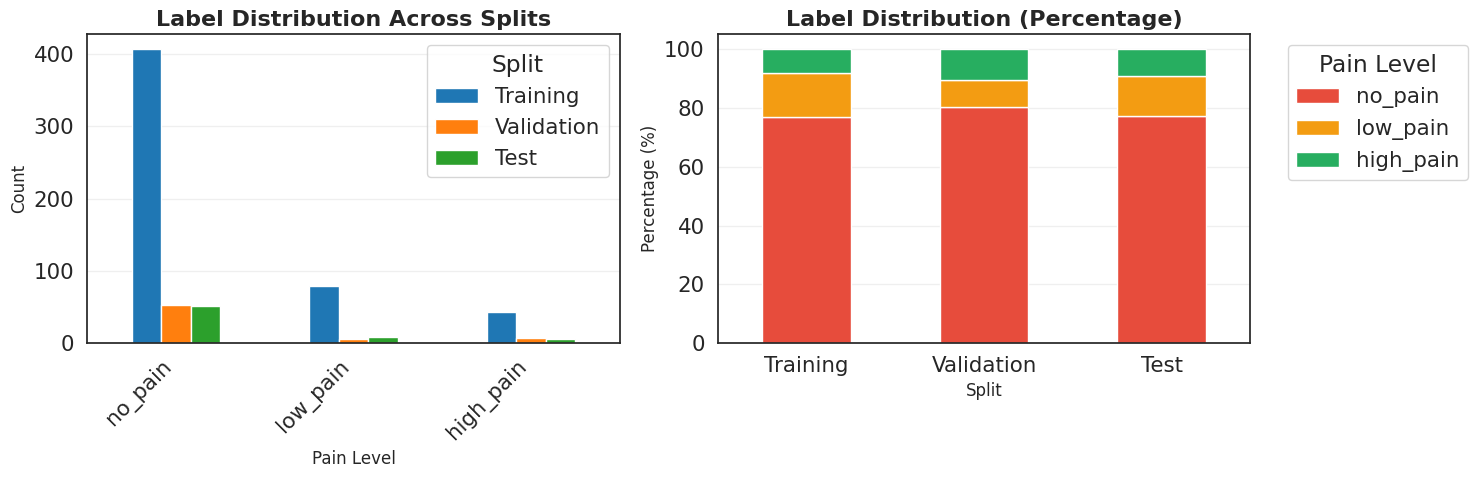

In [5]:
# @title Label distribution

def get_label_distribution(df, dataset_labels):
    """Count label distribution for a given dataframe using pandas operations."""
    # Get unique sample indices from the dataframe
    sample_indices = df['sample_index'].unique()

    # Filter labels for these samples and count occurrences
    labels = dataset_labels[dataset_labels['sample_index'].isin(sample_indices)]
    distribution = labels['label'].value_counts().to_dict()

    # Ensure all categories are present (even if count is 0)
    for label in ['no_pain', 'low_pain', 'high_pain']:
        distribution.setdefault(label, 0)

    return distribution

training_labels = get_label_distribution(df_train, dataset_labels)
validation_labels = get_label_distribution(df_val, dataset_labels)
test_labels = get_label_distribution(df_test, dataset_labels)

distribution_df = pd.DataFrame({
    'Training': training_labels,
    'Validation': validation_labels,
    'Test': test_labels
})

# Display the distribution table
print("\nLabel Distribution Across Splits:")
print("=" * 50)
print(distribution_df)
print("\nPercentages:")
print((distribution_df / distribution_df.sum() * 100).round(2))

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
distribution_df.plot(kind='bar', ax=axes[0], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
axes[0].set_title('Label Distribution Across Splits', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Pain Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Split')
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Stacked percentage plot
distribution_pct = distribution_df / distribution_df.sum() * 100
distribution_pct.T.plot(kind='bar', stacked=True, ax=axes[1],
                         color=['#e74c3c', '#f39c12', '#27ae60'])
axes[1].set_title('Label Distribution (Percentage)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Split', fontsize=12)
axes[1].set_ylabel('Percentage (%)', fontsize=12)
axes[1].legend(title='Pain Level', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [6]:
# @title Map labels for hierarchical classification

original_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Stage 1: Binary classification (no_pain vs pain)
stage1_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,  # pain
    'high_pain': 1,  # pain
}

# Stage 2: Binary classification on pain samples only (low_pain vs high_pain)
stage2_label_mapping = {
    'low_pain': 0,
    'high_pain': 1,
}

# Create labels for both stages
dataset_labels['original_label'] = dataset_labels['label'].copy()
dataset_labels['stage1_label'] = dataset_labels['label'].map(stage1_label_mapping)

# Create stage 2 labels (only for pain samples)
dataset_labels['stage2_label'] = dataset_labels['label'].map(stage2_label_mapping)

# Map original labels to integers for later use
dataset_labels['label'] = dataset_labels['label'].map(original_label_mapping)

print("Label counts:")
print(f"Stage 1 - No pain: {(dataset_labels['stage1_label'] == 0).sum()}, Pain: {(dataset_labels['stage1_label'] == 1).sum()}")
pain_samples = dataset_labels[dataset_labels['stage1_label'] == 1]
print(f"Stage 2 - Low pain: {(pain_samples['stage2_label'] == 0).sum()}, High pain: {(pain_samples['stage2_label'] == 1).sum()}")

dataset_labels.head(10)

Label counts:
Stage 1 - No pain: 511, Pain: 150
Stage 2 - Low pain: 94, High pain: 56


,sample_index,label,original_label,stage1_label,stage2_label
0,0,0,no_pain,0,NaN
1,1,0,no_pain,0,NaN
2,2,1,low_pain,1,0.0
3,3,0,no_pain,0,NaN
4,4,0,no_pain,0,NaN
5,5,0,no_pain,0,NaN
6,6,0,no_pain,0,NaN
7,7,0,no_pain,0,NaN
8,8,0,no_pain,0,NaN
9,9,0,no_pain,0,NaN


In [7]:
# @title Normalisation of joint data
joint_columns = dataset.columns.difference(['sample_index', 'time', 'is_pirate', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4'])

# Calculate the minimum and maximum values from the training data only
mins = df_train[joint_columns].min()
maxs = df_train[joint_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in joint_columns:
    # Check if max == min (constant column) to avoid division by zero
    if maxs[column] == mins[column]:
        print(f"Warning: Column {column} has constant value {mins[column]}, dropping it")
        # Drop constant columns from all datasets
        df_train = df_train.drop(columns=[column])
        df_val = df_val.drop(columns=[column])
        df_test = df_test.drop(columns=[column])
    else:
        df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])
        df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])

# Update joint_columns to only include non-constant columns
joint_columns = [col for col in joint_columns if col in df_train.columns]

## Making sequences

In [8]:
WINDOW_SIZE = 50
STRIDE = 10

def build_sequences(df, window=40, stride=5, stage='stage1'):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    label_column = 'stage1_label' if stage == 'stage1' else 'stage2_label'

    for id in df['sample_index'].unique():
        # Get the label for this sample
        sample_labels = dataset_labels[dataset_labels['sample_index'] == id]

        if len(sample_labels) == 0:
            continue

        label = sample_labels[label_column].values[0]

        if stage == 'stage2' and pd.isna(label):
            continue

        cols = df.columns.difference(['sample_index', 'time', 'joint_30'])
        temp = df[df['sample_index'] == id][cols].values

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing (use float32 for PyTorch compatibility)
    dataset = np.array(dataset, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    return dataset, labels

X_train_s1, y_train_s1 = build_sequences(df_train, WINDOW_SIZE, STRIDE, stage='stage1')
X_val_s1, y_val_s1 = build_sequences(df_val, WINDOW_SIZE, STRIDE, stage='stage1')
X_test_s1, y_test_s1 = build_sequences(df_test, WINDOW_SIZE, STRIDE, stage='stage1')

input_shape = X_train_s1.shape[1:]
num_classes_s1 = 2  # no_pain vs pain

train_ds_s1 = TensorDataset(torch.from_numpy(X_train_s1), torch.from_numpy(y_train_s1))
val_ds_s1 = TensorDataset(torch.from_numpy(X_val_s1), torch.from_numpy(y_val_s1))
test_ds_s1 = TensorDataset(torch.from_numpy(X_test_s1), torch.from_numpy(y_test_s1))

# Filter dataframes to only include pain samples
pain_sample_ids = dataset_labels[dataset_labels['stage1_label'] == 1]['sample_index'].values
df_train_pain = df_train[df_train['sample_index'].isin(pain_sample_ids)]
df_val_pain = df_val[df_val['sample_index'].isin(pain_sample_ids)]
df_test_pain = df_test[df_test['sample_index'].isin(pain_sample_ids)]

X_train_s2, y_train_s2 = build_sequences(df_train_pain, WINDOW_SIZE, STRIDE, stage='stage2')
X_val_s2, y_val_s2 = build_sequences(df_val_pain, WINDOW_SIZE, STRIDE, stage='stage2')
X_test_s2, y_test_s2 = build_sequences(df_test_pain, WINDOW_SIZE, STRIDE, stage='stage2')

num_classes_s2 = 2  # low_pain vs high_pain

# Convert numpy arrays to PyTorch datasets
train_ds_s2 = TensorDataset(torch.from_numpy(X_train_s2), torch.from_numpy(y_train_s2))
val_ds_s2 = TensorDataset(torch.from_numpy(X_val_s2), torch.from_numpy(y_val_s2))
test_ds_s2 = TensorDataset(torch.from_numpy(X_test_s2), torch.from_numpy(y_test_s2))

## Data loaders

In [9]:
BATCH_SIZE = 512

def make_loader(ds, batch_size, shuffle, drop_last):
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4 if num_workers > 0 else None,
    )

# Stage 1
train_loader_s1 = make_loader(train_ds_s1, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader_s1 = make_loader(val_ds_s1, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader_s1 = make_loader(test_ds_s1, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

for xb, yb in train_loader_s1:
    print(f"Stage 1 - Features batch shape: {xb.shape}, Labels batch shape: {yb.shape}")
    break

# Stage 2
train_loader_s2 = make_loader(train_ds_s2, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader_s2 = make_loader(val_ds_s2, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader_s2 = make_loader(test_ds_s2, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

for xb, yb in train_loader_s2:
    print(f"Stage 2 - Features batch shape: {xb.shape}, Labels batch shape: {yb.shape}")
    break

Stage 1 - Features batch shape: torch.Size([512, 50, 35]), Labels batch shape: torch.Size([512])
Stage 2 - Features batch shape: torch.Size([512, 50, 35]), Labels batch shape: torch.Size([512])


In [10]:
feature_cols = [col for col in df_train.columns if col not in ['sample_index', 'time']]
joint_indices = [i for i, col in enumerate(feature_cols) if col in joint_columns]

def add_noise(X, y, joint_indices, noise_level=0.01, augmentation_factor=2):
    augmented_X = [X]  # Start with original data
    augmented_y = [y]

    for i in range(augmentation_factor):
        X_noisy = X.copy()

        for joint_idx in joint_indices:
            # Generate noise for this specific feature across all samples and timesteps
            noise = np.random.normal(0, noise_level, (X.shape[0], X.shape[1])).astype(np.float32)

            # Add noise to this feature
            X_noisy[:, :, joint_idx] = X[:, :, joint_idx] + noise

            # Clip to [0, 1] range (normalized data)
            X_noisy[:, :, joint_idx] = np.clip(X_noisy[:, :, joint_idx], 0, 1)

        augmented_X.append(X_noisy)
        augmented_y.append(y)

    X_combined = np.concatenate(augmented_X, axis=0)
    y_combined = np.concatenate(augmented_y, axis=0)

    return X_combined, y_combined

NOISE_LEVEL = 0.03
AUGMENTATION_FACTOR = 3

# Apply augmentation to Stage 2
X_train_s2_aug, y_train_s2_aug = add_noise(
    X_train_s2,
    y_train_s2,
    joint_indices=joint_indices,
    noise_level=NOISE_LEVEL,
    augmentation_factor=AUGMENTATION_FACTOR
)

train_ds_s2_aug = TensorDataset(
    torch.from_numpy(X_train_s2_aug),
    torch.from_numpy(y_train_s2_aug)
)

# Replace Stage 2 training loader with augmented version
train_loader_s2 = make_loader(train_ds_s2_aug, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

## Model

In [11]:
# @title Custom model summary for recurrent layers
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [12]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

## Training

In [13]:
# @title Parameters

EPOCHS = 500

S1_PATIENCE = 50
S1_LEARNING_RATE = 1e-3
S1_HIDDEN_LAYERS = 2
S1_HIDDEN_SIZE = 96
S1_BIDIRECTIONAL = True
S1_RNN_TYPE = 'LSTM'
S1_DROPOUT_RATE = 0.3
S1_L2_LAMBDA = 1e-4
S1_GRADIENT_CLIP = 1.0

S2_PATIENCE = 20
S2_LEARNING_RATE = 1e-3
S2_HIDDEN_LAYERS = 2
S2_HIDDEN_SIZE = 128
S2_BIDIRECTIONAL = True
S2_RNN_TYPE = 'GRU'
S2_DROPOUT_RATE = 0.3
S2_L2_LAMBDA = 1e-3
S2_GRADIENT_CLIP = 0.5

criterion = nn.CrossEntropyLoss()

# Check class imbalance in Stage 2
print("\n" + "="*70)
print("STAGE 2 CLASS DISTRIBUTION")
print("="*70)
pain_sample_ids = dataset_labels[dataset_labels['stage1_label'] == 1]['sample_index'].values
df_train_pain_temp = df_train[df_train['sample_index'].isin(pain_sample_ids)]
_, y_train_s2_temp = build_sequences(df_train_pain_temp, WINDOW_SIZE, STRIDE, stage='stage2')
class_counts = np.bincount(y_train_s2_temp)
print(f"Training: Low pain={class_counts[0]}, High pain={class_counts[1]}")
print(f"Ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# Calculate class weights for imbalanced data
total_samples = len(y_train_s2_temp)
class_weights = torch.tensor([
    total_samples / (2 * class_counts[0]), # Weight for class 0 (low_pain)
    total_samples / (2 * class_counts[1])   # Weight for class 1 (high_pain)
], dtype=torch.float32).to(device)

print(f"Class weights: Low pain={class_weights[0]:.3f}, High pain={class_weights[1]:.3f}")
criterion_s2 = nn.CrossEntropyLoss(weight=class_weights)
print("="*70)


STAGE 2 CLASS DISTRIBUTION
Training: Low pain=948, High pain=516
Ratio: 1.84:1
Class weights: Low pain=0.772, High pain=1.419


In [14]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0, gradient_clip=None):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization
        gradient_clip (float): Maximum norm for gradient clipping (None to disable)

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Clip gradients to prevent explosion (if enabled)
        if gradient_clip is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)

        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [15]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [16]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty and has valid values before adding a histogram
            if param.numel() > 0 and torch.isfinite(param).all():
                try:
                    writer.add_histogram(f'{name}/weights', param.data, epoch)
                except ValueError:
                    pass  # Skip empty histograms
            if param.grad is not None:
                # Check if the gradient tensor is not empty and has valid values before adding a histogram
                if param.grad.numel() > 0 and torch.isfinite(param.grad).all():
                    try:
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)
                    except ValueError:
                        pass  # Skip empty histograms

In [17]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", gradient_clip=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")
        gradient_clip (float, optional): Maximum norm for gradient clipping (default: None)

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda, gradient_clip
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [18]:
# Initialize weights function
def init_weights(m):
    if isinstance(m, (nn.LSTM, nn.GRU, nn.RNN)):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)

# ========== STAGE 1 MODEL: No Pain vs Pain ==========
print("="*70)
print("STAGE 1 MODEL: No Pain vs Pain Classification")
print("="*70)

model_s1 = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=S1_HIDDEN_SIZE,
    num_layers=S1_HIDDEN_LAYERS,
    num_classes=num_classes_s1,  # 2 classes: no_pain, pain
    dropout_rate=S1_DROPOUT_RATE,
    bidirectional=S1_BIDIRECTIONAL,
    rnn_type=S1_RNN_TYPE
).to(device)

# Initialize weights
model_s1.apply(init_weights)
recurrent_summary(model_s1, input_size=input_shape)

# Set up TensorBoard logging
experiment_name_s1 = "stage1-no_pain_vs_pain"
writer_s1 = SummaryWriter("./"+logs_dir+"/"+experiment_name_s1)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer_s1.add_graph(model_s1, x)

# Define optimizer and scaler with stage-specific parameters
optimizer_s1 = torch.optim.AdamW(model_s1.parameters(), lr=S1_LEARNING_RATE, weight_decay=S1_L2_LAMBDA)
scaler_s1 = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print("\n" + "="*70)
print("STAGE 2 MODEL: Low Pain vs High Pain Classification")
print("="*70)



STAGE 1 MODEL: No Pain vs Pain Classification
-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 50, 192], [4, -1, 96]] 324,864        
classifier (Linear)       [-1, 2]                      386            
Total params: 325,250
Trainable params: 325,250
Non-trainable params: 0
-------------------------------------------------------------------------------

STAGE 2 MODEL: Low Pain vs High Pain Classification


In [19]:
model_s2 = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=S2_HIDDEN_SIZE,
    num_layers=S2_HIDDEN_LAYERS,
    num_classes=num_classes_s2,
    dropout_rate=S2_DROPOUT_RATE,
    bidirectional=S2_BIDIRECTIONAL,
    rnn_type=S2_RNN_TYPE
).to(device)

model_s2.apply(init_weights)
recurrent_summary(model_s2, input_shape)

experiment_name_s2 = "stage2-low_pain_vs_high_pain"
writer_s2 = SummaryWriter("./"+logs_dir+"/"+experiment_name_s2)
writer_s2.add_graph(model_s2, x)

# Define optimizer and scaler with stage-specific parameters
optimizer_s2 = torch.optim.AdamW(model_s2.parameters(), lr=S2_LEARNING_RATE, weight_decay=S2_L2_LAMBDA)
scaler_s2 = torch.amp.GradScaler(enabled=(device.type == 'cuda'))


-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 50, 256], [4, -1, 128]] 423,168        
classifier (Linear)       [-1, 2]                      514            
Total params: 423,682
Trainable params: 423,682
Non-trainable params: 0
-------------------------------------------------------------------------------


No Pain vs Pain Classification
Training 500 epochs...
Epoch   1/500 | Train: Loss=0.5512, F1 Score=0.6713 | Val: Loss=0.4996, F1 Score=0.7153
Epoch  10/500 | Train: Loss=0.2668, F1 Score=0.8986 | Val: Loss=0.3478, F1 Score=0.8549
Epoch  20/500 | Train: Loss=0.1497, F1 Score=0.9478 | Val: Loss=0.2412, F1 Score=0.9211
Epoch  30/500 | Train: Loss=0.1288, F1 Score=0.9566 | Val: Loss=0.2046, F1 Score=0.9273
Epoch  40/500 | Train: Loss=0.1075, F1 Score=0.9565 | Val: Loss=0.1891, F1 Score=0.9634
Epoch  50/500 | Train: Loss=0.0714, F1 Score=0.9723 | Val: Loss=0.2209, F1 Score=0.9576
Epoch  60/500 | Train: Loss=0.0913, F1 Score=0.9620 | Val: Loss=0.2076, F1 Score=0.9462
Epoch  70/500 | Train: Loss=0.0505, F1 Score=0.9814 | Val: Loss=0.2954, F1 Score=0.9422
Epoch  80/500 | Train: Loss=0.0666, F1 Score=0.9730 | Val: Loss=0.1870, F1 Score=0.9502
Epoch  90/500 | Train: Loss=0.0346, F1 Score=0.9891 | Val: Loss=0.2522, F1 Score=0.9651
Early stopping triggered after 92 epochs.
Best model restored from

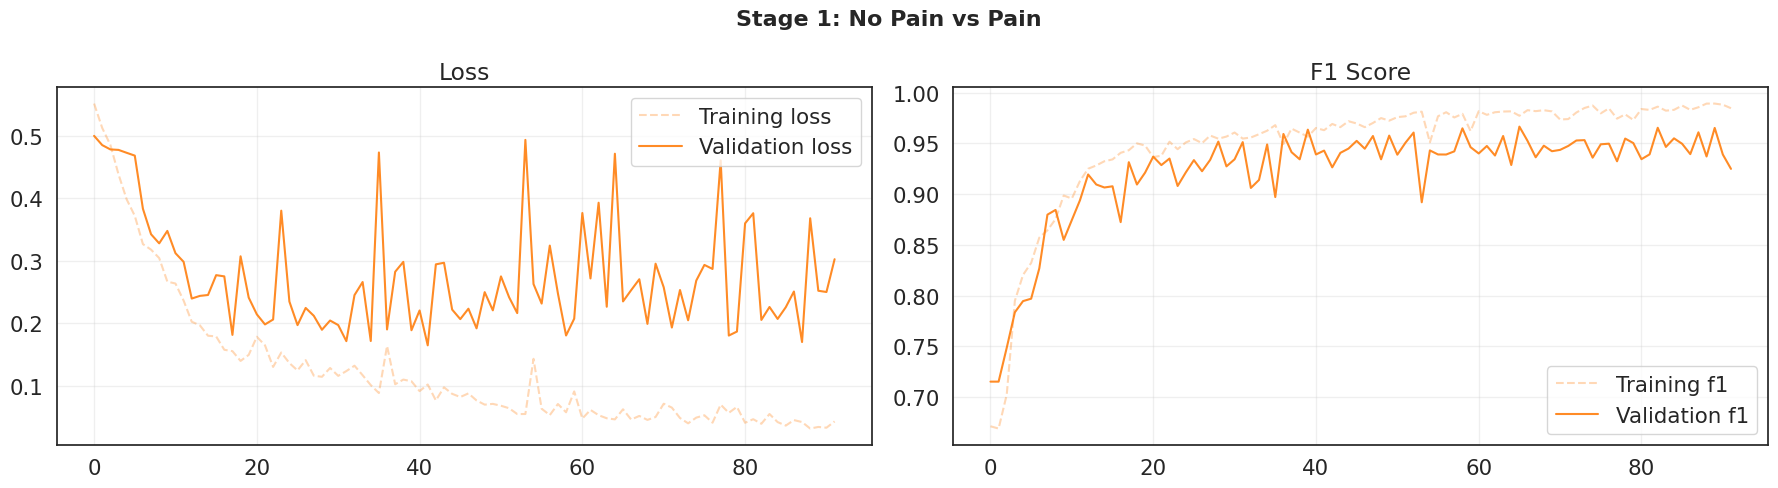

Best validation F1: 0.9664
CPU times: user 21.3 s, sys: 10.2 s, total: 31.5 s
Wall time: 50.2 s


In [20]:
%%time

print("="*70)
print("No Pain vs Pain Classification")
print("="*70)

model_s1, history_s1 = fit(
    model=model_s1,
    train_loader=train_loader_s1,
    val_loader=val_loader_s1,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer_s1,
    scaler=scaler_s1,
    device=device,
    writer=None,
    verbose=10,
    experiment_name=experiment_name_s1,
    patience=S1_PATIENCE,
    evaluation_metric="val_loss",
    mode='min',
    gradient_clip=S1_GRADIENT_CLIP
)

# Visualize Stage 1 training history
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.suptitle('Stage 1: No Pain vs Pain', fontsize=16, fontweight='bold')

ax1.plot(history_s1['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(history_s1['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history_s1['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(history_s1['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation F1: {max(history_s1['val_f1']):.4f}")


Low Pain vs High Pain Classification
Training 500 epochs...
Epoch   1/500 | Train: Loss=0.6949, F1 Score=0.5821 | Val: Loss=0.9611, F1 Score=0.3325
Epoch  10/500 | Train: Loss=0.4476, F1 Score=0.7944 | Val: Loss=1.0815, F1 Score=0.4310
Epoch  20/500 | Train: Loss=0.1771, F1 Score=0.9316 | Val: Loss=1.6599, F1 Score=0.5926
Epoch  30/500 | Train: Loss=0.0488, F1 Score=0.9831 | Val: Loss=0.6372, F1 Score=0.8976
Epoch  40/500 | Train: Loss=0.0107, F1 Score=0.9961 | Val: Loss=1.0417, F1 Score=0.8775
Epoch  50/500 | Train: Loss=0.0108, F1 Score=0.9962 | Val: Loss=0.9696, F1 Score=0.9231
Epoch  60/500 | Train: Loss=0.0059, F1 Score=0.9990 | Val: Loss=1.1072, F1 Score=0.9166
Early stopping triggered after 68 epochs.
Best model restored from epoch 48 with val_loss 0.0426


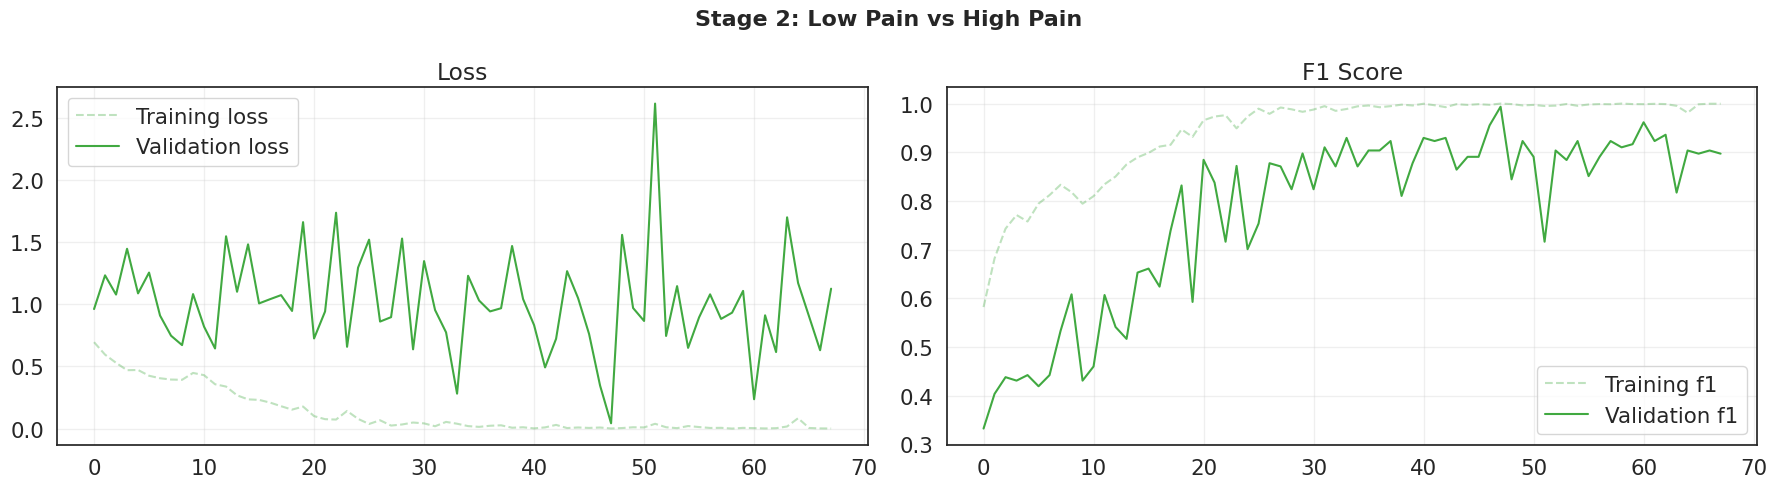

Best validation F1: 0.9936
CPU times: user 14.1 s, sys: 7.18 s, total: 21.3 s
Wall time: 32.3 s


In [21]:
%%time
print("\n" + "="*70)
print("Low Pain vs High Pain Classification")
print("="*70)

model_s2, history_s2 = fit(
    model=model_s2,
    train_loader=train_loader_s2,
    val_loader=val_loader_s2,
    epochs=EPOCHS,
    criterion=criterion_s2,
    optimizer=optimizer_s2,
    scaler=scaler_s2,
    device=device,
    writer=None,
    verbose=10,
    experiment_name=experiment_name_s2,
    patience=S2_PATIENCE,
    evaluation_metric="val_loss",
    mode='min',
    gradient_clip=S2_GRADIENT_CLIP
)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.suptitle('Stage 2: Low Pain vs High Pain', fontsize=16, fontweight='bold')

ax1.plot(history_s2['train_loss'], label='Training loss', alpha=0.3, color='#2ca02c', linestyle='--')
ax1.plot(history_s2['val_loss'], label='Validation loss', alpha=0.9, color='#2ca02c')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history_s2['train_f1'], label='Training f1', alpha=0.3, color='#2ca02c', linestyle='--')
ax2.plot(history_s2['val_f1'], label='Validation f1', alpha=0.9, color='#2ca02c')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best validation F1: {max(history_s2['val_f1']):.4f}")

Accuracy:  0.9545
Precision: 0.9551
Recall:    0.9545
F1 Score:  0.9542


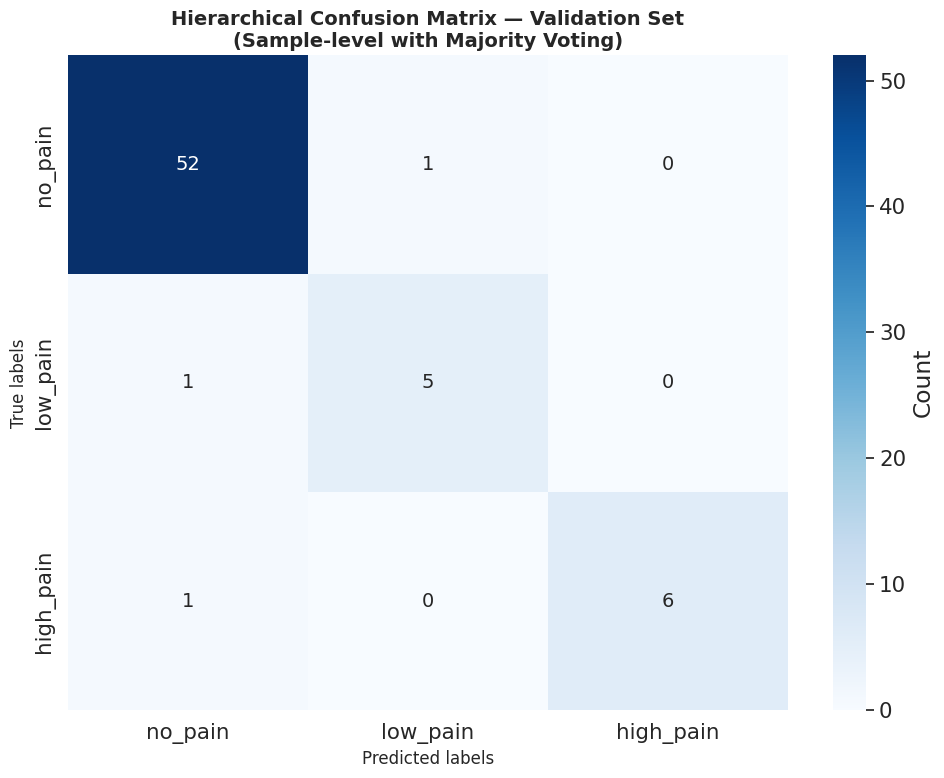


Per-class metrics:
no_pain   : 52/53 correct (0.9811)
low_pain  : 5/6 correct (0.8333)
high_pain : 6/7 correct (0.8571)


In [22]:
# Build sequences grouped by sample for validation
def build_test_sequences(df, window=40, stride=5):
    """Build sequences from data, grouped by sample_index"""
    sequences_by_sample = {}

    for sample_id in df['sample_index'].unique():
        cols = df.columns.difference(['sample_index', 'time'])
        temp = df[df['sample_index'] == sample_id][cols].values

        # Build overlapping windows for this sample
        sample_sequences = []
        idx = 0
        while idx + window <= len(temp):
            sample_sequences.append(temp[idx:idx + window])
            idx += stride

        sequences_by_sample[sample_id] = np.array(sample_sequences, dtype=np.float32)

    return sequences_by_sample

val_sequences = build_test_sequences(df_val, WINDOW_SIZE, STRIDE)

from scipy import stats

val_preds = []
val_targets = []

model_s1.eval()
model_s2.eval()

with torch.no_grad():
    for sample_id in sorted(val_sequences.keys()):
        sequences = val_sequences[sample_id]

        # Convert to tensor and move to device
        sequences_tensor = torch.from_numpy(sequences).to(device)

        # Stage 1: Predict no_pain vs pain for all windows of this sample
        logits_s1 = model_s1(sequences_tensor)
        window_preds_s1 = logits_s1.argmax(dim=1)  # 0=no_pain, 1=pain

        # Initialize final predictions for windows
        window_final_preds = torch.zeros_like(window_preds_s1)

        # Find windows where pain was predicted
        pain_mask = (window_preds_s1 == 1)

        if pain_mask.any():
            # Stage 2: For pain windows, predict low_pain vs high_pain
            pain_sequences = sequences_tensor[pain_mask]
            logits_s2 = model_s2(pain_sequences)
            window_preds_s2 = logits_s2.argmax(dim=1)  # 0=low_pain, 1=high_pain

            # Map to final labels: low_pain=1, high_pain=2
            window_final_preds[pain_mask] = window_preds_s2 + 1

        # Apply majority voting across all windows for this sample
        window_predictions = window_final_preds.cpu().numpy()
        final_prediction = stats.mode(window_predictions, keepdims=False)[0]

        # Get true label for this sample (original 3-class label)
        true_label = dataset_labels[dataset_labels['sample_index'] == sample_id]['label'].values[0]

        val_preds.append(final_prediction)
        val_targets.append(true_label)

val_preds = np.array(val_preds)
val_targets = np.array(val_targets)

val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
val_rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)

print(f"Accuracy:  {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall:    {val_rec:.4f}")
print(f"F1 Score:  {val_f1:.4f}")

cm = confusion_matrix(val_targets, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['no_pain', 'low_pain', 'high_pain'],
            yticklabels=['no_pain', 'low_pain', 'high_pain'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted labels', fontsize=12)
plt.ylabel('True labels', fontsize=12)
plt.title('Hierarchical Confusion Matrix — Validation Set\n(Sample-level with Majority Voting)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nPer-class metrics:")
for i, class_name in enumerate(['no_pain', 'low_pain', 'high_pain']):
    class_mask = (val_targets == i)
    if class_mask.any():
        class_acc = accuracy_score(val_targets[class_mask], val_preds[class_mask])
        class_count = class_mask.sum()
        class_correct = (val_preds[class_mask] == val_targets[class_mask]).sum()
        print(f"{class_name:10s}: {class_correct}/{class_count} correct ({class_acc:.4f})")

## Submission

In [23]:
# Load the actual test dataset (for submission)
if IN_COLAB:
    test_dataset = pd.read_csv('pirate_pain_test.csv')
else:
    test_dataset = pd.read_csv('dataset/pirate_pain_test.csv')

# Preprocess the test dataset (same as training data)
test_dataset['n_legs'] = preprocess_stringed_num(test_dataset['n_legs'])
test_dataset['n_hands'] = preprocess_stringed_num(test_dataset['n_hands'])
test_dataset['n_eyes'] = preprocess_stringed_num(test_dataset['n_eyes'])

# Create the same binary pirate feature
test_dataset['is_pirate'] = (test_dataset['n_legs'] == 1).astype(np.int8)

# Drop the redundant columns
test_dataset = test_dataset.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

# Normalize joint columns using the same min/max from training data
for column in joint_columns:
    if maxs[column] == mins[column]:
        test_dataset[column] = 0
    else:
        test_dataset[column] = (test_dataset[column] - mins[column]) / (maxs[column] - mins[column])

# Build sequences for test data (without labels)
def build_test_sequences(df, window=40, stride=5):
    """Build sequences from test data, grouped by sample_index"""
    sequences_by_sample = {}

    for sample_id in df['sample_index'].unique():
        cols = df.columns.difference(['sample_index', 'time', 'joint_30'])
        temp = df[df['sample_index'] == sample_id][cols].values

        # Build overlapping windows for this sample
        sample_sequences = []
        idx = 0
        while idx + window <= len(temp):
            sample_sequences.append(temp[idx:idx + window])
            idx += stride

        sequences_by_sample[sample_id] = np.array(sample_sequences, dtype=np.float32)

    return sequences_by_sample

# Generate sequences for each sample
test_sequences = build_test_sequences(test_dataset, WINDOW_SIZE, STRIDE)

reverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

predictions = []
model_s1.eval()
model_s2.eval()

with torch.no_grad():
    for sample_id in sorted(test_sequences.keys()):
        sequences = test_sequences[sample_id]

        # Convert to tensor and move to device
        sequences_tensor = torch.from_numpy(sequences).to(device)

        # Stage 1: Predict no_pain vs pain for all windows
        logits_s1 = model_s1(sequences_tensor)
        window_preds_s1 = logits_s1.argmax(dim=1)  # 0=no_pain, 1=pain

        # Initialize final predictions
        window_final_preds = torch.zeros_like(window_preds_s1)

        # Find windows where pain was predicted
        pain_mask = (window_preds_s1 == 1)

        if pain_mask.any():
            # Stage 2: For pain windows, predict low_pain vs high_pain
            pain_sequences = sequences_tensor[pain_mask]
            logits_s2 = model_s2(pain_sequences)
            window_preds_s2 = logits_s2.argmax(dim=1)  # 0=low_pain, 1=high_pain

            # Map to final labels: low_pain=1, high_pain=2
            window_final_preds[pain_mask] = window_preds_s2 + 1

        # Aggregate window predictions using majority voting
        window_predictions = window_final_preds.cpu().numpy()
        from scipy import stats
        final_prediction = stats.mode(window_predictions, keepdims=False)[0]

        # Convert numeric prediction to string label
        label_str = reverse_label_mapping[final_prediction]

        predictions.append({
            'sample_index': sample_id,
            'label': label_str
        })

submission_df = pd.DataFrame(predictions)

submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{x:03d}")

submission_df = submission_df.sort_values('sample_index').reset_index(drop=True)

print("\nPrediction distribution:")
print(submission_df['label'].value_counts().sort_index())

submission_path = 'submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nSubmission file saved to: {submission_path}")
print("Submission file preview:")
!head -25 submission.csv


Prediction distribution:
label
high_pain      81
low_pain      189
no_pain      1054
Name: count, dtype: int64

Submission file saved to: submission.csv
Submission file preview:
sample_index,label
000,no_pain
001,no_pain
002,no_pain
003,no_pain
004,no_pain
005,no_pain
006,no_pain
007,no_pain
008,no_pain
009,no_pain
010,no_pain
011,no_pain
012,no_pain
013,no_pain
014,no_pain
015,no_pain
016,low_pain
017,no_pain
018,low_pain
019,no_pain
020,no_pain
021,no_pain
022,no_pain
023,low_pain
